In [2]:
import numpy as np
from pyswarm import pso

# 全局变量用于追踪迭代数据
iteration_count = 0
best_value = np.inf
best_solution = None

# 用户参数
antenna_gains_db = np.array([15, 12, 13, 10, 20, 11])
required_rates = np.array([10, 5, 0, 3, 1, 0])
channel_gains_db = np.array([-100, -105, -105, -115, -120, -125])

# 系统参数
total_power = 30
bandwidth = 20e6
noise_power_density = -174
noise_power = 10 ** ((noise_power_density - 30) / 10) * bandwidth

# 转换信道增益为线性值
channel_gains = 10 ** ((channel_gains_db + 130) / 10)

# 目标函数：最大化总安全容量
def objective(P):
    global iteration_count, best_value, best_solution
    iteration_count += 1

    user_indices = [0, 1, 3, 4]
    eavesdropper_indices = [2, 5]
    rates = np.zeros(len(user_indices))
    eavesdropper_rates = np.zeros(len(eavesdropper_indices))
    total_power_transmitted = np.sum(P)

    for i in range(len(P)):
        interference = total_power_transmitted - P[i]
        SINR = P[i] * channel_gains[i] / (interference + noise_power)
        rate = np.log2(1 + SINR)
        if i in user_indices:
            rates[user_indices.index(i)] = rate
        if i in eavesdropper_indices:
            eavesdropper_rates[eavesdropper_indices.index(i)] = rate

    secure_rates = rates - np.sum(eavesdropper_rates)
    total_secure_rate = np.sum(secure_rates)
    
    if -total_secure_rate < best_value:
        best_value = -total_secure_rate
        best_solution = P.copy()

    return -total_secure_rate

# 约束条件：确保总功率不超过设定限制
def constraint(P):
    return total_power - np.sum(P)

# 设置PSO算法的参数
lb = [0.1] * 6
ub = [total_power / 2] * 6

# 运行PSO算法
xopt, fopt = pso(objective, lb, ub, ieqcons=[constraint], swarmsize=150, omega=0.7, phip=1.2, phig=1.2, maxiter=1000)
# xopt, fopt = pso(objective, lb, ub, ieqcons=[constraint], swarmsize=150, omega=1.2, phip=1.2, phig=1.2, maxiter=1000)

# 输出结果
print("最优功率分配：", xopt)
print("最大化的总安全容量：", -fopt)
print("总迭代次数：", iteration_count)
print("历史最佳解：", best_solution)
print("历史最高安全容量：", -best_value)


Stopping search: Swarm best objective change less than 1e-08
最优功率分配： [8.72634406 8.6448788  0.1        7.5482076  4.88056883 0.1       ]
最大化的总安全容量： 16.567668360644483
总迭代次数： 62167
历史最佳解： [14.12290938 10.73279557  0.1        13.97827503 11.42924099  0.23508014]
历史最高安全容量： 17.816905490583245


Stopping search: maximum iterations reached --> 100


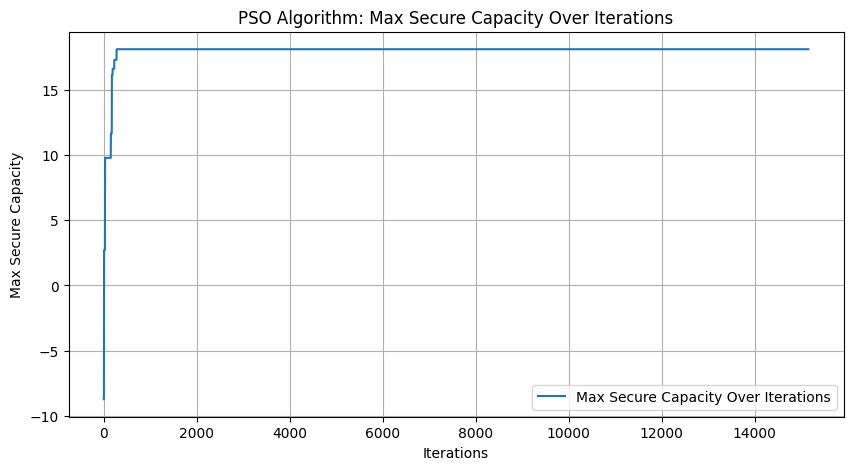

In [43]:
from pyswarm import pso
import numpy as np
import matplotlib.pyplot as plt

# 全局变量用于追踪迭代数据和绘图
iteration_count = 0
best_value = -np.inf  # 初始化为负无穷大，因为我们希望最大化安全容量
best_solution = None
max_capacity_history = []  # 存储每次迭代中最大安全容量的历史记录
change_threshold = 1e-6  # 定义收敛的阈值
convergence_iter = 10  # 定义判断收敛的迭代次数
converged_count = 0  # 追踪达到收敛阈值的连续次数

# 用户参数
antenna_gains_db = np.array([15, 12, 13, 10, 20, 11])
required_rates = np.array([10, 5, 0, 3, 1, 0])
channel_gains_db = np.array([-100, -105, -105, -115, -120, -125])

# 系统参数
total_power = 30
bandwidth = 20e6
noise_power_density = -174
noise_power = 10 ** ((noise_power_density - 30) / 10) * bandwidth

# 转换信道增益为线性值
channel_gains = 10 ** ((channel_gains_db + 130) / 10)

# 目标函数：最大化总安全容量
def objective(P):
    global iteration_count, best_value, best_solution, max_capacity_history, converged_count
    iteration_count += 1

    user_indices = [0, 1, 3, 4]
    eavesdropper_indices = [2, 5]
    rates = np.zeros(len(user_indices))
    eavesdropper_rates = np.zeros(len(eavesdropper_indices))
    total_power_transmitted = np.sum(P)

    for i in range(len(P)):
        interference = total_power_transmitted - P[i]
        SINR = P[i] * channel_gains[i] / (interference + noise_power)
        rate = np.log2(1 + SINR)
        if i in user_indices:
            rates[user_indices.index(i)] = rate
        if i in eavesdropper_indices:
            eavesdropper_rates[eavesdropper_indices.index(i)] = rate

    secure_rates = rates - np.sum(eavesdropper_rates)
    total_secure_rate = np.sum(secure_rates)
    
    if total_secure_rate > best_value:
        best_value = total_secure_rate
        best_solution = P.copy()

    max_capacity_history.append(best_value)  # 记录最大安全容量的历史

    # 检查是否收敛
    if len(max_capacity_history) > 1 and abs(max_capacity_history[-1] - max_capacity_history[-2]) < change_threshold:
        converged_count += 1
    else:
        converged_count = 0

    if converged_count >= convergence_iter:
        return False  # 告知PSO停止迭代

    return -total_secure_rate

# 约束条件：确保总功率不超过设定限制
def constraint(P):
    return total_power - np.sum(P)

# 设置PSO算法的参数
lb = [0.1] * 6
ub = [total_power / 2] * 6

# 运行PSO算法
xopt, fopt = pso(objective, lb, ub, ieqcons=[constraint], swarmsize=150, omega=0.7, phip=1.2, phig=1.2, maxiter=100)

# 绘制最大安全容量的变化曲线
plt.figure(figsize=(10, 5))
plt.plot(max_capacity_history, label="Max Secure Capacity Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Max Secure Capacity")
plt.title("PSO Algorithm: Max Secure Capacity Over Iterations")
plt.legend()
plt.grid(True)
plt.show()


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


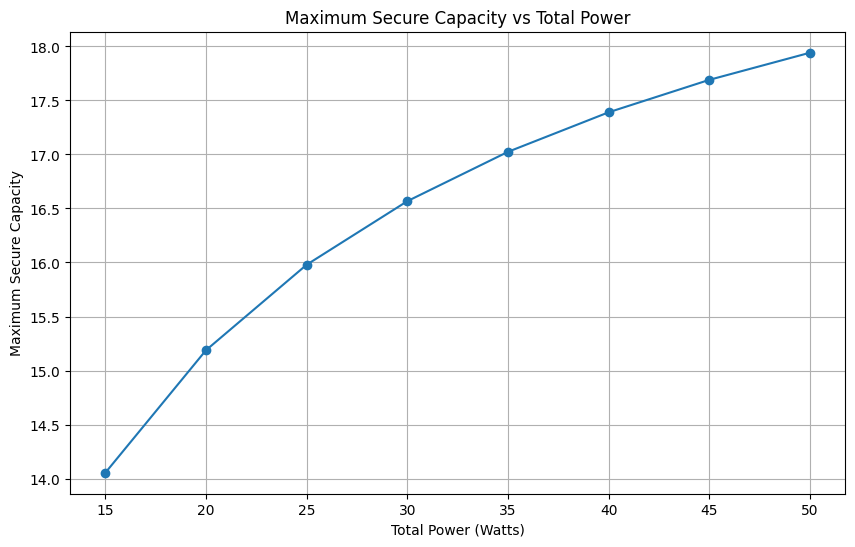

In [52]:
import numpy as np
from pyswarm import pso
import matplotlib.pyplot as plt

# 用户参数
antenna_gains_db = np.array([15, 12, 13, 10, 20, 11])
required_rates = np.array([10, 5, 0, 3, 1, 0])
channel_gains_db = np.array([-100, -105, -105, -115, -120, -125])

# 系统参数
bandwidth = 20e6
noise_power_density = -174
noise_power = 10 ** ((noise_power_density - 30) / 10) * bandwidth

# 转换信道增益为线性值
channel_gains = 10 ** ((channel_gains_db + 130) / 10)

# 初始化存储总功率和对应的最大安全容量
total_powers = np.arange(15, 51, 5)
max_safe_capacities = []

# 遍历不同的总功率设置
for total_power in total_powers:
    # 目标函数：最大化总安全容量
    def objective(P):
        user_indices = [0, 1, 3, 4]
        eavesdropper_indices = [2, 5]
        rates = np.zeros(len(user_indices))
        eavesdropper_rates = np.zeros(len(eavesdropper_indices))
        total_power_transmitted = np.sum(P)

        for i in range(len(P)):
            interference = total_power_transmitted - P[i]
            SINR = P[i] * channel_gains[i] / (interference + noise_power)
            rate = np.log2(1 + SINR)
            if i in user_indices:
                rates[user_indices.index(i)] = rate
            if i in eavesdropper_indices:
                eavesdropper_rates[eavesdropper_indices.index(i)] = rate

        secure_rates = rates - np.sum(eavesdropper_rates)
        total_secure_rate = np.sum(secure_rates)
        return -total_secure_rate

    # 约束条件：确保总功率不超过设定限制
    def constraint(P):
        return total_power - np.sum(P)

    # 设置PSO算法的参数
    lb = [0.1] * 6
    ub = [total_power / 2] * 6
    xopt, fopt = pso(objective, lb, ub, ieqcons=[constraint], swarmsize=150, omega=0.8, phip=1.2, phig=1.2, maxiter=1000)
    max_safe_capacities.append(-fopt)

# 绘制结果
plt.figure(figsize=(10, 6))
plt.plot(total_powers, max_safe_capacities, marker='o', linestyle='-')
plt.title("Maximum Secure Capacity vs Total Power")
plt.xlabel("Total Power (Watts)")
plt.ylabel("Maximum Secure Capacity")
plt.grid(True)
plt.show()


In [9]:
import numpy as np
from deap import base, creator, tools, algorithms
import random
from pyswarm import pso

# Define system parameters
total_power = 30
antenna_gains_db = np.array([15, 12, 13, 10, 20, 11])
channel_gains_db = np.array([-100, -105, -105, -115, -120, -125])
bandwidth = 20e6
noise_power_density = -174
noise_power = 10 ** ((noise_power_density - 30) / 10) * bandwidth
channel_gains = 10 ** ((channel_gains_db + 130) / 10)

# Setup DEAP for genetic algorithm
if not hasattr(creator, 'FitnessMax'):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if not hasattr(creator, 'Individual'):
    creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0.1, total_power / 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 6)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", objective)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Define the objective function for maximizing total secure capacity
def objective(P):
    rates = np.zeros(4)
    eavesdropper_rates = np.zeros(2)
    total_power_transmitted = np.sum(P)
    for i in range(4):  # Normal users
        interference = total_power_transmitted - P[i] + noise_power
        if interference == 0:
            interference = 1e-10  # 防止除零错误
        SINR = P[i] * channel_gains[i] / interference
        rates[i] = np.log2(1 + max(0, SINR))  # 确保1+SINR为正

    for i in range(2):  # Eavesdroppers
        interference = total_power_transmitted - P[i+4] + noise_power
        if interference == 0:
            interference = 1e-10  # 防止除零错误
        SINR = P[i+4] * channel_gains[i+4] / interference
        eavesdropper_rates[i] = np.log2(1 + max(0, SINR))  # 确保1+SINR为正

    secure_rates = rates - np.max(eavesdropper_rates)
    total_secure_rate = np.sum(secure_rates)
    return -total_secure_rate,

# 包装 objective 函数以适应 PSO
def pso_objective(P):
    return objective(P)[0]  # 从元组中提取单个数值

# 使用 GA 结果调整 PSO 参数
def custom_pso():
    # 根据 GA 最优解调整 PSO 参数
    phip = 1.5  # 增加认知参数以探索 GA 的最佳解
    phig = 1.0  # 社交参数
    omega = 0.5  # 惯性权重
    lb = [0.1] * 6
    ub = [total_power / 2] * 6
    xopt, fopt = pso(pso_objective, lb, ub, ieqcons=[constraint], swarmsize=150, omega=omega, phip=phip, phig=phig, maxiter=1000)
    return xopt, fopt

# 定义约束以确保总功率限制
def constraint(P):
    return [total_power - np.sum(P)]

# 使用调整后的参数运行 PSO
xopt, fopt = custom_pso()

# 打印结果
print("Optimal power allocation:", xopt)
print("Maximized total secure capacity:", -fopt)

Stopping search: Swarm best objective change less than 1e-08
Optimal power allocation: [7.75392731 7.67783958 7.67555615 6.6926755  0.1        0.1       ]
Maximized total secure capacity: 25.149075882742434


In [34]:
import numpy as np
from deap import base, creator, tools, algorithms
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx

# 设置系统参数
total_power = 30
antenna_gains_db = np.array([15, 12, 13, 10, 20, 11])
channel_gains_db = np.array([-100, -105, -105, -115, -120, -125])
bandwidth = 20e6
noise_power_density = -174
noise_power = 10 ** ((noise_power_density - 30) / 10) * bandwidth
channel_gains = 10 ** ((channel_gains_db + 130) / 10)

# 初始化DEAP库中的适应度和个体类
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.rand)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 6)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 定义目标函数
def objective(X):
    # 将X转换为NumPy数组，确保处理的统一性
    X = np.array(X)
    
    # 确保X是二维的
    if X.ndim == 1:
        X = X.reshape(1, -1)
    n_particles = X.shape[0]  # 获取粒子数量（解的数量）
    secure_rates = np.zeros(n_particles)  # 初始化安全速率数组

    for j in range(n_particles):
        P = X[j, :]  # 获取单个粒子（解向量）
        rates = np.zeros(4)
        eavesdropper_rates = np.zeros(2)
        total_power_transmitted = np.sum(P) * total_power  # Scale by total power

        for i in range(4):  # Normal users
            interference = total_power_transmitted - P[i] * total_power + noise_power
            SINR = (P[i] * total_power) * channel_gains[i] / np.maximum(interference, 1e-10)
            rates[i] = np.log2(1 + np.maximum(0, SINR))

        for i in range(2):  # Eavesdroppers
            interference = total_power_transmitted - P[i+4] * total_power + noise_power
            SINR = (P[i+4] * total_power) * channel_gains[i+4] / np.maximum(interference, 1e-10)
            eavesdropper_rates[i] = np.log2(1 + np.maximum(0, SINR))

        secure_rates[j] = np.sum(rates) - np.max(eavesdropper_rates)

    return -secure_rates  # 返回一个数组，每个元素是一个粒子的目标函数值

toolbox.register("evaluate", objective)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# 运行遗传算法
population = toolbox.population(n=50)
# result, log = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=100, verbose=False)
result, log = algorithms.eaSimple(population, toolbox, cxpb=0.72, mutpb=0.2, ngen=100, verbose=False)

best_ga = tools.selBest(result, 1)[0]

# 运行粒子群优化
# options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
options = {'c1': 1.2, 'c2': 1.2, 'w': 0.6}
optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=6, options=options, bounds=(np.zeros(6), np.ones(6)))
cost, pos = optimizer.optimize(objective, iters=100)

# 打印结果
print("Optimal power allocation from PSO:", pos * total_power)
print("Maximized total secure capacity from PSO:", -cost)


2024-04-19 21:15:29,664 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.2, 'c2': 1.2, 'w': 0.6}
pyswarms.single.global_best: 100%|█████████████|100/100, best_cost=-25.3
2024-04-19 21:15:30,172 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -25.26263096098425, best pos: [0.93329193 0.65184498 0.92661681 0.80513696 0.0072407  0.01118736]


Optimal power allocation from PSO: [23.3322983  16.29612444 23.16542021 20.12842405  0.18101759  0.2796841 ]
Maximized total secure capacity from PSO: 25.26263096098425


2024-04-19 21:20:18,801 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.2, 'c2': 1.2, 'w': 0.6}
pyswarms.single.global_best: 100%|█████████████|100/100, best_cost=-25.1
2024-04-19 21:20:19,285 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -25.119117802577534, best pos: [0.76168905 0.64790687 0.75220056 0.61915205 0.03399815 0.00131738]
2024-04-19 21:20:19,714 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.2, 'c2': 1.2, 'w': 0.6}
pyswarms.single.global_best: 100%|█████████████|100/100, best_cost=-25.3
2024-04-19 21:20:20,262 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -25.258618307059372, best pos: [0.87451543 0.89791016 0.83924014 0.63470498 0.01678351 0.00279924]
2024-04-19 21:20:20,739 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.2, 'c2': 1.2, 'w': 0.6}
pyswarms.single.global_best: 100%|█████████████|100/100, best_cost=-25.2
2024-04-19 21:2

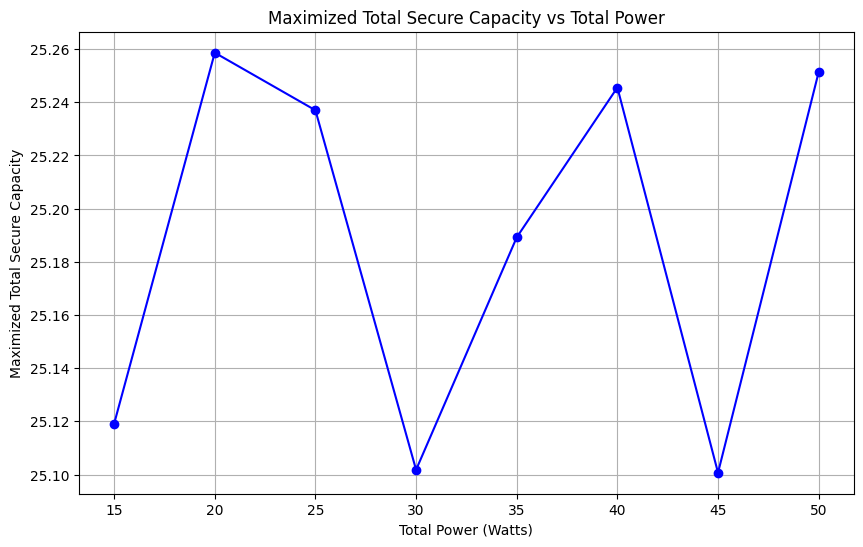

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
import pyswarms as ps

# 检查并创建适应度和个体类
if not hasattr(creator, 'FitnessMax'):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if not hasattr(creator, 'Individual'):
    creator.create("Individual", list, fitness=creator.FitnessMax)

# 设置系统参数
total_power = 30  # 初始总功率，将在循环中调整
antenna_gains_db = np.array([15, 12, 13, 10, 20, 11])
channel_gains_db = np.array([-100, -105, -105, -115, -120, -125])
bandwidth = 20e6
noise_power_density = -174
noise_power = 10 ** ((noise_power_density - 30) / 10) * bandwidth
channel_gains = 10 ** ((channel_gains_db + 130) / 10)
total_powers = np.arange(15, 51, 5)  # 总功率从15到50，步长为5

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.rand)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 6)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# 目标函数
def objective(X):
    X = np.array(X)  # 确保X是NumPy数组
    if X.ndim == 1:
        X = X.reshape(1, -1)
    n_particles = X.shape[0]
    secure_rates = np.zeros(n_particles)

    for j in range(n_particles):
        P = X[j, :]
        rates = np.zeros(4)
        eavesdropper_rates = np.zeros(2)
        total_power_transmitted = np.sum(P) * total_power

        for i in range(4):
            interference = total_power_transmitted - P[i] * total_power + noise_power
            SINR = (P[i] * total_power) * channel_gains[i] / np.maximum(interference, 1e-10)
            rates[i] = np.log2(1 + np.maximum(0, SINR))

        for i in range(2):
            interference = total_power_transmitted - P[i+4] * total_power + noise_power
            SINR = (P[i+4] * total_power) * channel_gains[i+4] / np.maximum(interference, 1e-10)
            eavesdropper_rates[i] = np.log2(1 + np.maximum(0, SINR))

        secure_rates[j] = np.sum(rates) - np.max(eavesdropper_rates)

    return -secure_rates  # 返回一个数组，每个元素是一个粒子的目标函数值

toolbox.register("evaluate", objective)

# 运行遗传算法和粒子群优化，并绘制安全容量变化曲线
max_capacities = []
for total_power in total_powers:
    population = toolbox.population(n=50)
    result, log = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=100, verbose=False)
    best_ga = tools.selBest(result, 1)[0]

    options = {'c1': 1.2, 'c2': 1.2, 'w': 0.6}
    optimizer = ps.single.GlobalBestPSO(n_particles=50, dimensions=6, options=options, bounds=(np.zeros(6), np.ones(6)))
    cost, pos = optimizer.optimize(objective, iters=100)

    max_capacities.append(-cost)

plt.figure(figsize=(10, 6))
plt.plot(total_powers, max_capacities, marker='o', linestyle='-', color='b')
plt.title("Maximized Total Secure Capacity vs Total Power")
plt.xlabel("Total Power (Watts)")
plt.ylabel("Maximized Total Secure Capacity")
plt.grid(True)
plt.show()
